In [1]:
import os
import sys
import numpy as np
import scipy
import scipy.sparse as sp
from scipy.spatial.transform import Rotation as R
from scipy.linalg import expm
from scipy.sparse import block_diag
from tqdm import tqdm

sys.path.append(os.path.abspath("code"))  # Add folder to path
from pr3_utils import *

##### Data

In [2]:
dataset = "00"  ## Change the dataset number give it as a string
datapath = "/Users/varunmoparthi/Desktop/ECE276A/ECE276A_PR3/data/dataset" + dataset + "/dataset" + dataset + ".npy"
datapath_img = "/Users/varunmoparthi/Desktop/ECE276A/ECE276A_PR3/data/dataset" + dataset + "/dataset" + dataset + "_imgs.npy"
data = load_data(datapath)
image_data = np.load(datapath_img, allow_pickle = True).item()

In [3]:
v_t = data[0]
ω_t = data[1]
timestamps = data[2]
features = data[3]
k_l = data[4]
k_r = data[5]
extL_T_imu = data[6]
extR_T_imu = data[7]
m, n = v_t.shape
v_t.shape, ω_t.shape, timestamps.shape, features.shape


((3755, 3), (3755, 3), (3755,), (4, 5376, 3755))

### Part - 1: IMU localization via EKF prediction

In [4]:
def ekf_pred(v, ω, τ, μ_prior, Σ_prior, W):
    ζ = axangle2twist(np.concatenate((v, ω)))  
    ad_ζ = axangle2adtwist(np.concatenate((v, ω)))
    
    μ_pred = μ_prior @ expm(τ * ζ)
    Σ_pred = (expm(-τ * ad_ζ) @ Σ_prior @ expm(-τ * ad_ζ).T) + τ * W

    return μ_pred, Σ_pred

In [5]:
μ = np.eye(4)  
T_Σ = 0.01
Σ = T_Σ * np.eye(6)  
W = np.eye(6)
μ_pred = []
Σ_pred = []
for i in range(m - 1):
    v, ω = v_t[i, :], ω_t[i, :] 
    τ = timestamps[i + 1] - timestamps[i] 
    μ, Σ = ekf_pred(v, ω, τ, μ, Σ, W)
    μ_pred.append(μ)
    Σ_pred.append(Σ)

μ_pred = np.array(μ_pred)

Text(0.5, 1.0, 'IMU localization via EKF prediction for Dataset00')

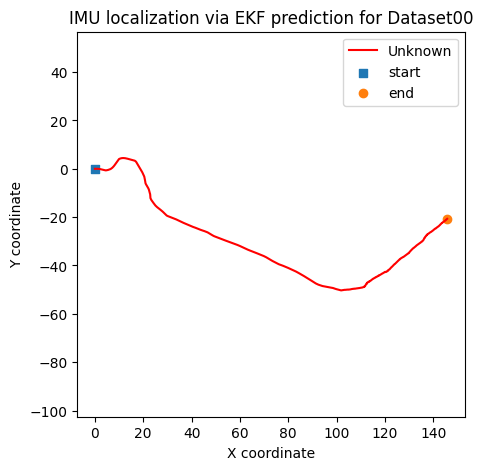

In [6]:
fig, ax = visualize_trajectory_2d(μ_pred)
ax.set_xlabel('X coordinate')
ax.set_ylabel("Y coordinate")
ax.set_title(f"IMU localization via EKF prediction for Dataset{dataset}")

### Part - 3: Landmark mapping via EKF update

In [9]:
oTc = np.array([
    [0, -1,  0, 0],
    [0,  0, -1, 0],
    [1,  0,  0, 0],
    [0,  0,  0, 1]
])

P =  np.array([
    [1.0,  0.0,  0, 0],
    [0,  1.0,  0, 0],
    [1,  0,  1.0, 0]
])

In [10]:
def triangulate_landmark(left_point, right_point, left_intrinsic, right_intrinsic, left_extrinsic, right_extrinsic):

    left_point_homogeneous = np.append(left_point, 1)
    right_point_homogeneous = np.append(right_point, 1)

    left_projection = left_intrinsic @ (oTc @ left_extrinsic)[:3]
    right_projection = right_intrinsic @ (oTc @ right_extrinsic)[:3]
    A = np.vstack([
        left_point_homogeneous[0] * left_projection[2] - left_projection[0],
        left_point_homogeneous[1] * left_projection[2] - left_projection[1],
        right_point_homogeneous[0] * right_projection[2] - right_projection[0],
        right_point_homogeneous[1] * right_projection[2] - right_projection[1]
    ])

    U, sigma, Vt = np.linalg.svd(A)
    triangulated_point_homogeneous = Vt[-1] 

    triangulated_point = triangulated_point_homogeneous[:3] / triangulated_point_homogeneous[3]
    return triangulated_point


In [76]:
features_sampled = features[:, ::4, :] ## Some form of sampled features to speed up landmarking you can control this by changing the number
_, num_marks, _ = features_sampled.shape

In [77]:
T_Σ_landmark = 100

μ_landmark = np.zeros((3, num_marks), dtype=float)
Σ_landmark = np.eye(3 * num_marks, dtype=float) * T_Σ_landmark
vist_landmark = np.full(num_marks, False, dtype=bool)

for i in range(m - 1):
    T_tplus1 = μ_pred[i]
    feats_i = features_sampled[:, :, i]

    H_list, z_tplus1i, z_tplus1, μ_t, feats_id = [], [], [], [], []
    for id in np.where(np.all(feats_i > 0, axis=0))[0]:
        if vist_landmark[id]:
            feats_id.append(id)

            μ_tj = np.hstack([μ_landmark[:, id], 1.0])
            μ_t.append(μ_landmark[:, id])

            H_tplus1_L = k_l @ (der_pi((oTc @ inversePose(extL_T_imu)) @ inversePose(T_tplus1) @ μ_tj))[:3, :] @ (oTi_L @ inversePose(T_tplus1) @ P.T)
            H_tplus1_R = k_r @ (der_pi((oTc @ inversePose(extR_T_imu)) @ inversePose(T_tplus1) @ μ_tj))[:3, :] @ (oTi_R @ inversePose(T_tplus1) @ P.T)
            H_list.append(np.concatenate([H_tplus1_L[:2, :], H_tplus1_R[:2, :]]))

            z_tplus1i_R = (k_r @ projection((oTc @ inversePose(extR_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3])[:2]
            z_tplus1i_L = (k_l @ projection((oTc @ inversePose(extL_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3])[:2]
            z_tplus1i.append(np.concatenate([z_tplus1i_L, z_tplus1i_R]))
            z_tplus1.append(feats_i[:, id])

        if not vist_landmark[id]:
            coord = triangulate_landmark(feats_i[:2, id], feats_i[2:, id], k_l, k_r, inversePose(extL_T_imu), inversePose(extR_T_imu))
            if np.linalg.norm(T_tplus1[:3, 3] - (T_tplus1 @ np.hstack([coord, 1]))[:3]) <= 100:
                μ_landmark[:, id] = (T_tplus1 @ np.hstack([coord, 1]))[:3]
                vist_landmark[id] = True

    if len(feats_id) != 0:

        Σ_landmark_id = np.repeat(3 * np.array(feats_id), 3) + np.tile(np.arange(3), len(np.array(feats_id)))
        Σ_t = Σ_landmark[np.ix_(Σ_landmark_id, Σ_landmark_id)]
        H_tplus1 = block_diag(H_list, format="csr")
        IxV = np.kron(np.eye(len(H_list)), np.eye(4) * 100)

        K = Σ_t @ H_tplus1.T @ np.linalg.pinv(H_tplus1 @ Σ_t @ H_tplus1.T + IxV)
        μ_tplus1 = (np.vstack(μ_t).flatten() + (K @ (np.vstack(z_tplus1) - np.vstack(z_tplus1i)).flatten())).reshape(-1, 3)
        Σ_tplus1 = Σ_t - K @ H_tplus1 @ Σ_t

        Σ_landmark[np.ix_(Σ_landmark_id, Σ_landmark_id)] = Σ_tplus1
        μ_landmark[:, np.array(feats_id)] = μ_tplus1.T


Text(0.5, 1.0, 'Landmark mapping via EKF update for Dataset01')

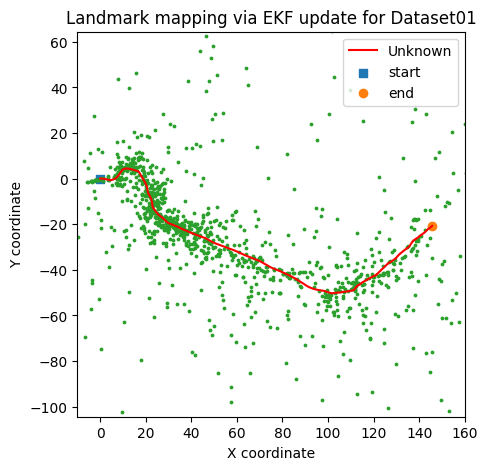

In [78]:
fig, ax = visualize_trajectory_2d(μ_pred)
ax.scatter(μ_landmark[0,:], μ_landmark[1,:], s=3)
ax.set_xlim(-10, 160)
ax.set_ylim(-80, 40)
ax.set_xlabel('X coordinate')
ax.set_ylabel("Y coordinate")
ax.set_title(f"Landmark mapping via EKF update for Dataset01")

### Part - 4: Visual-inertial SLAM

In [ ]:
features_sampled = features[:, ::4, :]  
_, num_marks, _ = features_sampled.shape
T_Σ_landmark = 100
μ_landmark = np.zeros((3, num_marks), dtype=float) 
Σ_landmark = np.eye(3 * num_marks, dtype=float) * T_Σ_landmark  
vist_landmark = np.full(num_marks, False, dtype=bool)  

for i in range(len(timestamps) - 1):
   
    T_tplus1 = μ_pred[i]
    Σ = Σ_pred[i]
    feats_i = features_sampled[:, :, i] 
    H_list, z_tplus1i, z_tplus1, feats_id = [], [], [], []
    for id in np.where(np.all(feats_i > 0, axis=0))[0]:
        if vist_landmark[id]:
            feats_id.append(id)
            μ_tj = np.hstack([μ_landmark[:, id], 1.0])  

            H_tplus1_L = k_l @ der_pi((oTc @ inversePose(extL_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3, :] @ (oTc @ inversePose(T_tplus1) @ P.T)
            H_tplus1_R = k_r @ der_pi((oTc @ inversePose(extR_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3, :] @ (oTc @ inversePose(T_tplus1) @ P.T)
            H_list.append(np.concatenate([H_tplus1_L[:2, :], H_tplus1_R[:2, :]]))

            z_tplus1i_R = (k_r @ projection((oTc @ inversePose(extR_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3])[:2]
            z_tplus1i_L = (k_l @ projection((oTc @ inversePose(extL_T_imu)) @ inversePose(T_tplus1) @ μ_tj)[:3])[:2]
            z_tplus1i.append(np.concatenate([z_tplus1i_L, z_tplus1i_R]))
            z_tplus1.append(feats_i[:, id])

        if not vist_landmark[id]:
            coord = triangulate_landmark(feats_i[:2, id], feats_i[2:, id], k_l, k_r, inversePose(extL_T_imu), inversePose(extR_T_imu))
            if np.linalg.norm(T_tplus1[:3, 3] - (T_tplus1 @ np.hstack([coord, 1]))[:3]) <= 100:
                μ_landmark[:, id] = (T_tplus1 @ np.hstack([coord, 1]))[:3]
                vist_landmark[id] = True

    if len(feats_id) != 0:

        H_tplus1 = np.vstack(H_list) 
        IxV = np.kron(np.eye(len(H_list)), np.eye(4) * 100)
        K = Σ @ H_tplus1.T @ np.linalg.pinv(H_tplus1 @ Σ @ H_tplus1.T + IxV)   
        μ_update = K @ np.vstack(z_tplus1) - np.vstack(z_tplus1i)  
        μ = μ @ expm(axangle2twist(μ_update.flatten())) 

        Σ = (np.eye(6) - K @ H_tplus1) @ Σ

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 3)